# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
from dqn_agent import Agent
from collections import deque

import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment (Baseline)

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [11]:
# Deep Q-Learning function

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0,
        eps_end=0.01, eps_decay=0.995, train_mode=True, ckpt_path='checkpoint.pth'):
    """Deep Q-Learning.
    
 
 Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
        ckpt_path (str) :  path to save the model
        
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    moving_avgs = [] # list of moving averages
    print(n_episodes)
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = (int)(agent.act(state, eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score+=reward
            if done: break
        scores_window.append(score)
        scores.append(score)
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
        if moving_avg >= 16.0:
            print(moving_avg)
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avg))
            if train_mode:
                torch.save(agent.qnetwork_local.state_dict(), ckpt_path)
            break
    return scores, moving_avgs


## Standard DQN + replay buffer (no double, no dueling)

1500
Episode 0	Average Score: -1.00
Episode 100	Average Score: 1.19
Episode 200	Average Score: 4.50
Episode 300	Average Score: 6.93
Episode 400	Average Score: 9.65
Episode 500	Average Score: 12.75
Episode 600	Average Score: 13.73
Episode 700	Average Score: 14.91
Episode 800	Average Score: 15.42
Episode 900	Average Score: 15.34
Episode 972	Average Score: 16.0216.02

Environment solved in 872 episodes!	Average Score: 16.02


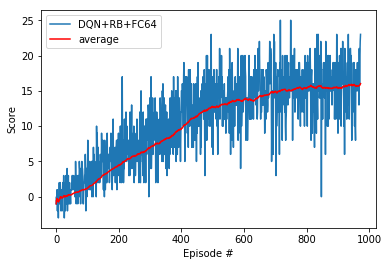

In [7]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              fc1_units=64, fc2_units=64, use_double=False, use_dueling=False)
scores, moving_avgs = dqn(n_episodes=1500, ckpt_path='checkpoints/v1_checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN+RB+FC64')
plt.plot(np.arange(len(scores)), moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

### Test the trained model 

In [ ]:
## Test the saved agent
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load the weights from file
checkpoint = 'checkpoints/v1_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 500
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        #agent.step(state, action, reward, next_state, done) # do the learning

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 1	Average Score: 14.00
Episode 2	Average Score: 13.50
Episode 3	Average Score: 13.00
Episode 4	Average Score: 14.75
Episode 5	Average Score: 13.20
Episode 6	Average Score: 14.00
Episode 7	Average Score: 14.57
Episode 8	Average Score: 14.12
Episode 9	Average Score: 14.00
Episode 10	Average Score: 14.50
Episode 11	Average Score: 14.09
Episode 12	Average Score: 14.50
Episode 13	Average Score: 14.46
Episode 14	Average Score: 14.21
Episode 15	Average Score: 14.27
Episode 16	Average Score: 14.62
Episode 17	Average Score: 14.71
Episode 18	Average Score: 14.72
Episode 19	Average Score: 14.79
Episode 20	Average Score: 14.90
Episode 21	Average Score: 14.90
Episode 22	Average Score: 14.91
Episode 23	Average Score: 14.96
Episode 24	Average Score: 14.92
Episode 25	Average Score: 15.04
Episode 26	Average Score: 15.12
Episode 27	Average Score: 15.11
Episode 28	Average Score: 15.04
Episode 29	Average Score: 14.72
Episode 30	Average Score: 14.67
Episode 31	Average Score: 14.52
Episode 32	Averag

## Standard DQN + replay buffer (with double, no dueling)

1500
Episode 0	Average Score: -1.00
Episode 100	Average Score: 0.98
Episode 200	Average Score: 4.11
Episode 300	Average Score: 7.42
Episode 400	Average Score: 10.87
Episode 500	Average Score: 13.65
Episode 600	Average Score: 14.49
Episode 700	Average Score: 15.36
Episode 800	Average Score: 15.03
Episode 887	Average Score: 16.0116.01

Environment solved in 787 episodes!	Average Score: 16.01


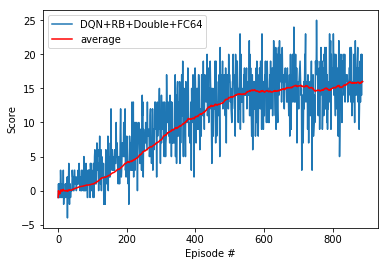

In [7]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              fc1_units=64, fc2_units=64, use_double=True, use_dueling=False)
scores, moving_avgs = dqn(n_episodes=1500, ckpt_path='checkpoints/v2_checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN+RB+Double+FC64')
plt.plot(np.arange(len(scores)), moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

### Test the trained model

Episode 1	Average Score: 21.00
Episode 2	Average Score: 19.50
Episode 3	Average Score: 17.67
Episode 4	Average Score: 19.25
Episode 5	Average Score: 17.80
Episode 6	Average Score: 18.50
Episode 7	Average Score: 19.14
Episode 8	Average Score: 18.75
Episode 9	Average Score: 18.11
Episode 10	Average Score: 17.60


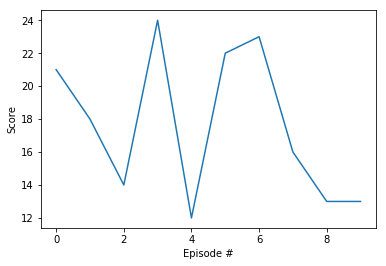

In [10]:
## Test the saved agent
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load the weights from file
checkpoint = 'checkpoints/v2_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        #agent.step(state, action, reward, next_state, done) # do the learning

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Standard DQN + replay buffer (no double, with dueling)

1500
Episode 0	Average Score: -1.00
Episode 100	Average Score: 1.54
Episode 200	Average Score: 7.45
Episode 300	Average Score: 11.01
Episode 400	Average Score: 15.38
Episode 500	Average Score: 15.35
Episode 585	Average Score: 16.0716.07

Environment solved in 485 episodes!	Average Score: 16.07


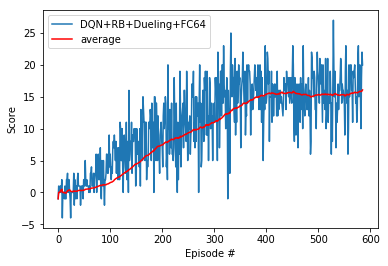

In [7]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, seed=0,
              fc1_units=64, fc2_units=64, use_double=False, use_dueling=True)
scores, moving_avgs = dqn(n_episodes=1500, eps_decay=0.98, eps_end=0.02, ckpt_path='checkpoints/v3_checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN+RB+Dueling+FC64')
plt.plot(np.arange(len(scores)), moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

Episode 1	Average Score: 14.00
Episode 2	Average Score: 16.00
Episode 3	Average Score: 17.00
Episode 4	Average Score: 17.75
Episode 5	Average Score: 18.20
Episode 6	Average Score: 18.67
Episode 7	Average Score: 18.29
Episode 8	Average Score: 17.88
Episode 9	Average Score: 17.33
Episode 10	Average Score: 17.50


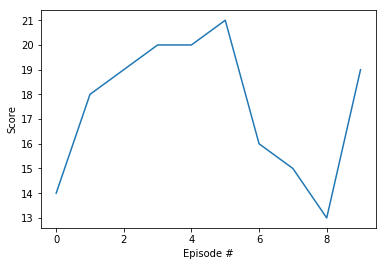

In [8]:
## Test the saved agent
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load the weights from file
checkpoint = 'checkpoints/v3_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        #agent.step(state, action, reward, next_state, done) # do the learning

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Standard DQN + replay buffer (with double, with dueling)

1500
Episode 0	Average Score: 1.00
Episode 100	Average Score: 1.36
Episode 200	Average Score: 7.92
Episode 300	Average Score: 13.10
Episode 400	Average Score: 13.84
Episode 500	Average Score: 15.15
Episode 523	Average Score: 16.0016.0

Environment solved in 423 episodes!	Average Score: 16.00


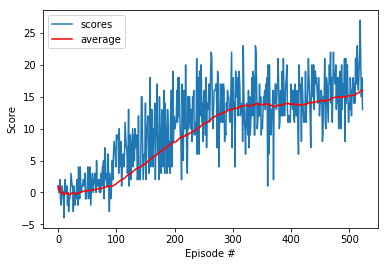

In [13]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, seed=0,
              fc1_units=64, fc2_units=64, use_double=True, use_dueling=True)
scores, moving_avgs = dqn(n_episodes=1500, eps_decay=0.98, eps_end=0.02, ckpt_path='checkpoints/v4_checkpoint.pth')
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='scores')
plt.plot(np.arange(len(scores)),moving_avgs , c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()


Episode 1	Average Score: 14.00
Episode 2	Average Score: 14.50
Episode 3	Average Score: 12.00
Episode 4	Average Score: 12.50
Episode 5	Average Score: 13.20
Episode 6	Average Score: 13.50
Episode 7	Average Score: 14.14
Episode 8	Average Score: 14.50
Episode 9	Average Score: 13.33
Episode 10	Average Score: 13.20


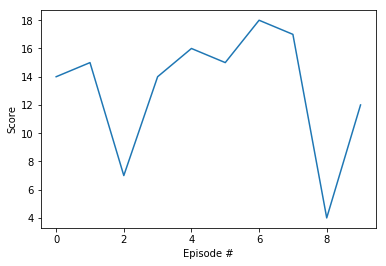

In [14]:
## Test the saved agent
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load the weights from file
checkpoint = 'checkpoints/v4_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        #agent.step(state, action, reward, next_state, done) # do the learning

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Standard DQN + replay buffer (with double, with dueling)

1500
Episode 0	Average Score: -1.00
Episode 100	Average Score: 0.66
Episode 200	Average Score: 4.02
Episode 300	Average Score: 7.11
Episode 400	Average Score: 11.06
Episode 500	Average Score: 12.47
Episode 600	Average Score: 14.40
Episode 700	Average Score: 15.37
Episode 800	Average Score: 15.54
Episode 900	Average Score: 15.57
Episode 917	Average Score: 16.0416.04

Environment solved in 817 episodes!	Average Score: 16.04


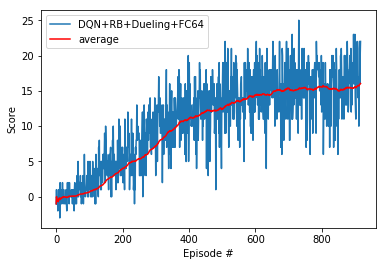

In [14]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, seed=0,
              fc1_units=64, fc2_units=64, use_double=False, use_dueling=True)
scores, moving_avgs = dqn(n_episodes=1500,ckpt_path='checkpoints/v5_checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN+RB+Dueling+FC64')
plt.plot(np.arange(len(scores)), moving_avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()


#### We are done here. Looks like among all experiments `Standard DQN + replay buffer (no double, with dueling)` with Epsilon decay 0.98 and end 0.02 worked best. lets close the environment.